In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


df = pd.read_csv('german_credit_data.csv')


In [18]:
# Exploratory Data Analysis Before Preprocessing
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [19]:
df.info()
df['Job'] = df['Job'].astype(object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
Unnamed: 0          1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(5), object(6)
memory usage: 86.0+ KB


In [20]:
# id 삭제
df.drop(df.columns[0], axis=1, inplace=True)

# describe
df.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [21]:
# missing data
df.isnull().sum()
m_df = df.isnull().sum()
print(m_df) # print count of null value

m_df = m_df.reset_index()
m_df.columns = ['column', 'count'] # initialize the column name
m_df['ratio'] = m_df['count']/df.shape[0] # add the column
print(m_df.loc[m_df['ratio'] != 0]) # print values that features have null value


Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64
             column  count  ratio
4   Saving accounts    183  0.183
5  Checking account    394  0.394


In [22]:
# missing data 삭제

df.dropna(inplace=True)
print(df.isnull().sum()) # print count of null value

# 데이터 개수
print(len(df))


Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
522


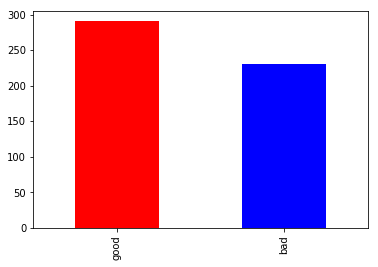

In [23]:
# Check the target variable
df['Risk'].value_counts().plot(kind = 'bar', color=['red', 'blue'])
plt.show()


['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


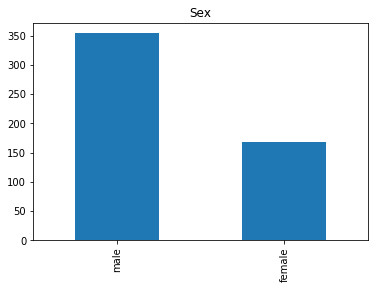

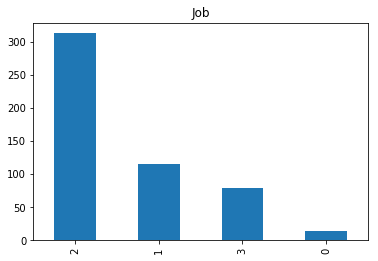

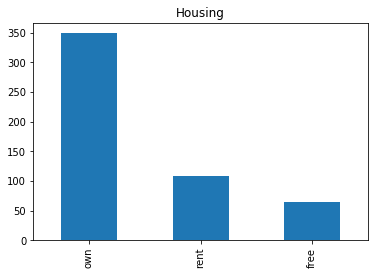

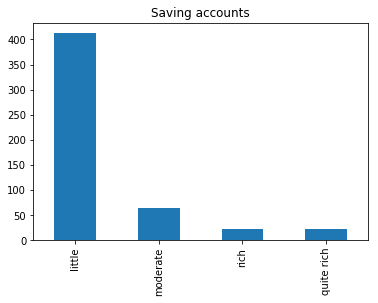

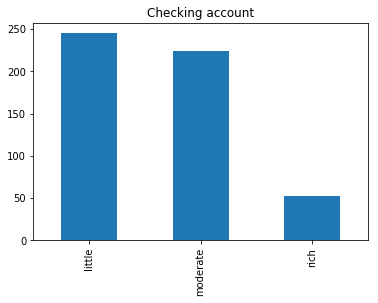

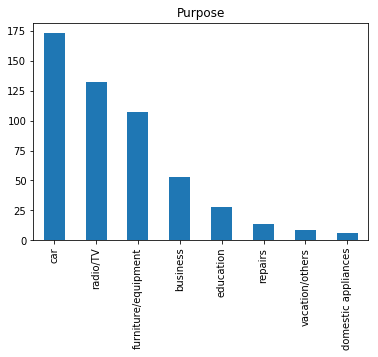

In [24]:
# Check the categorical data
category_feature = [col for col in df.columns if df[col].dtypes == 'object' and col != 'Risk']
print(category_feature)

for col in category_feature:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()

['Credit amount', 'Duration', 'Age']


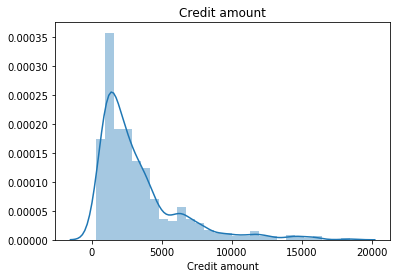

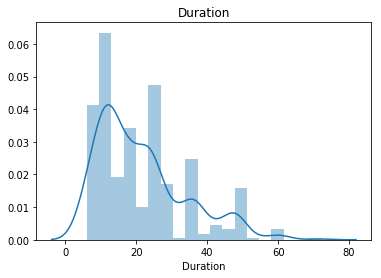

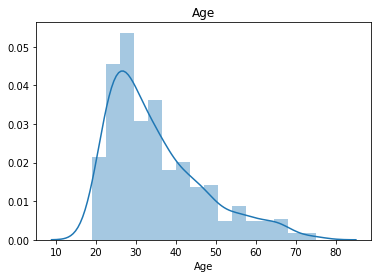

In [25]:
# Check the numerical data
numerical_feature = list(set(df.columns) - set(category_feature) - set(['Risk']))
print(numerical_feature)

for col in numerical_feature:
    sns.distplot(df.loc[df[col].notnull(), col])
    plt.title(col)
    plt.show()

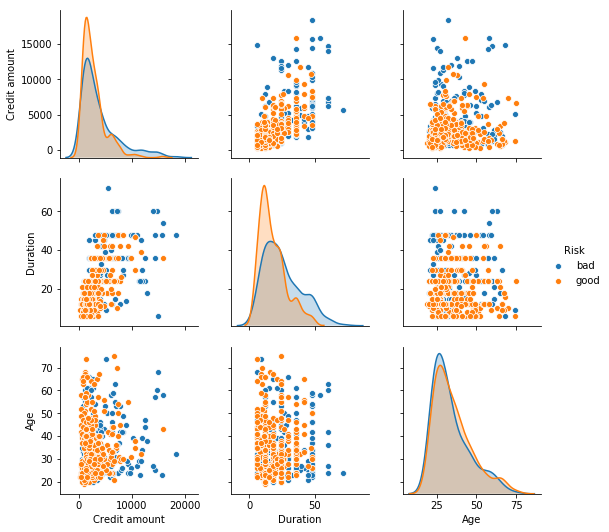

In [26]:
sns.pairplot(df[list(numerical_feature) + ['Risk']], hue = 'Risk'
                , x_vars = numerical_feature, y_vars = numerical_feature)

plt.show()

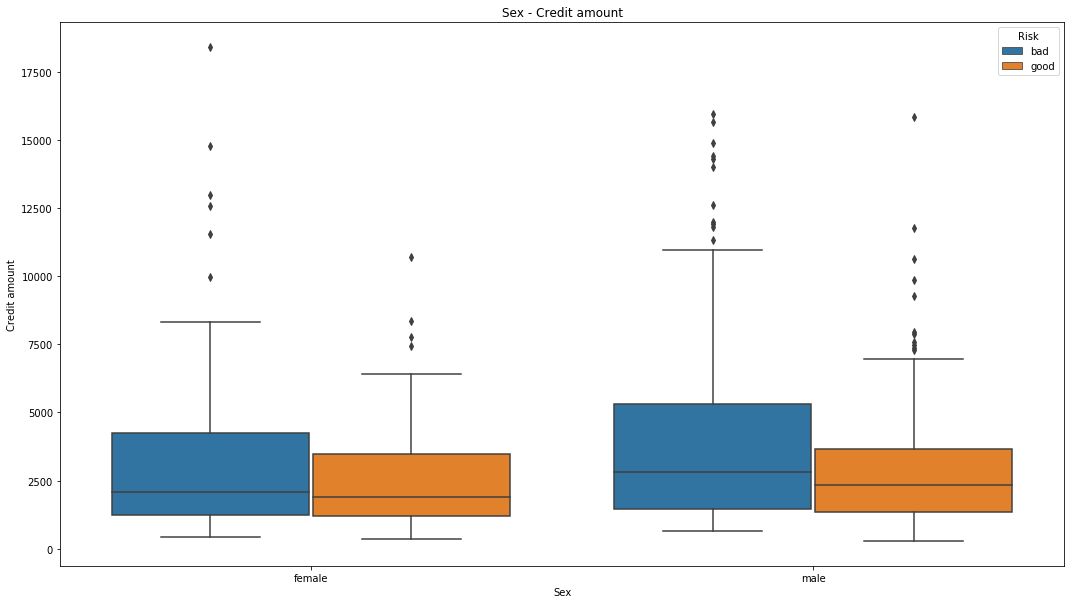

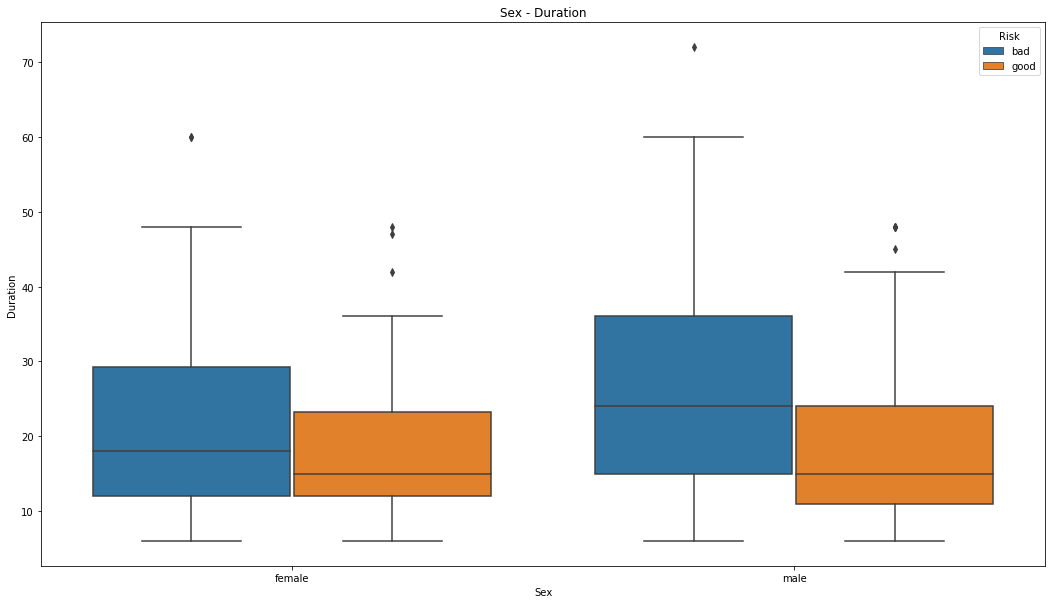

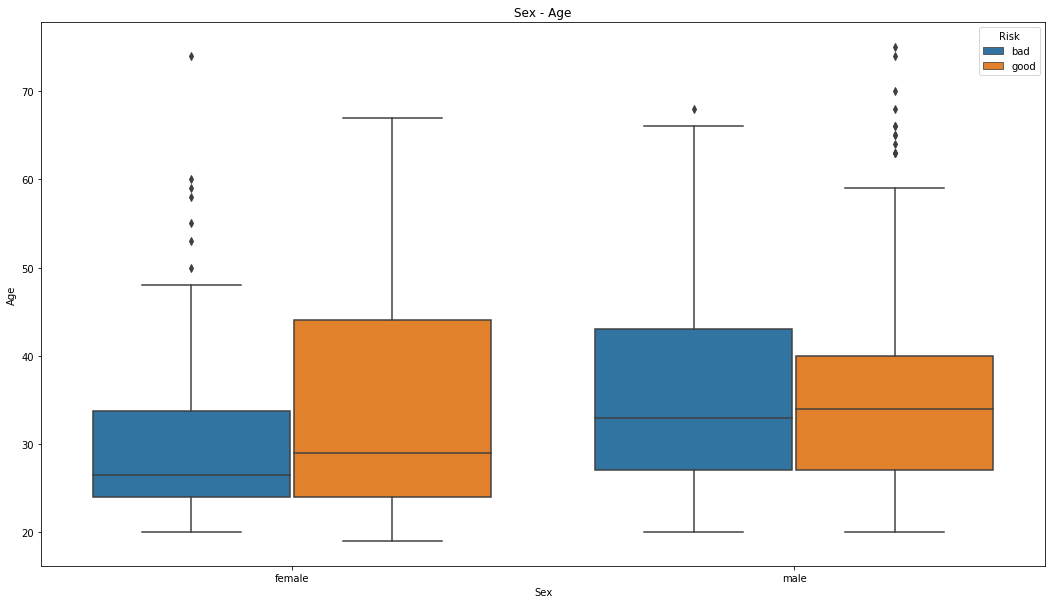

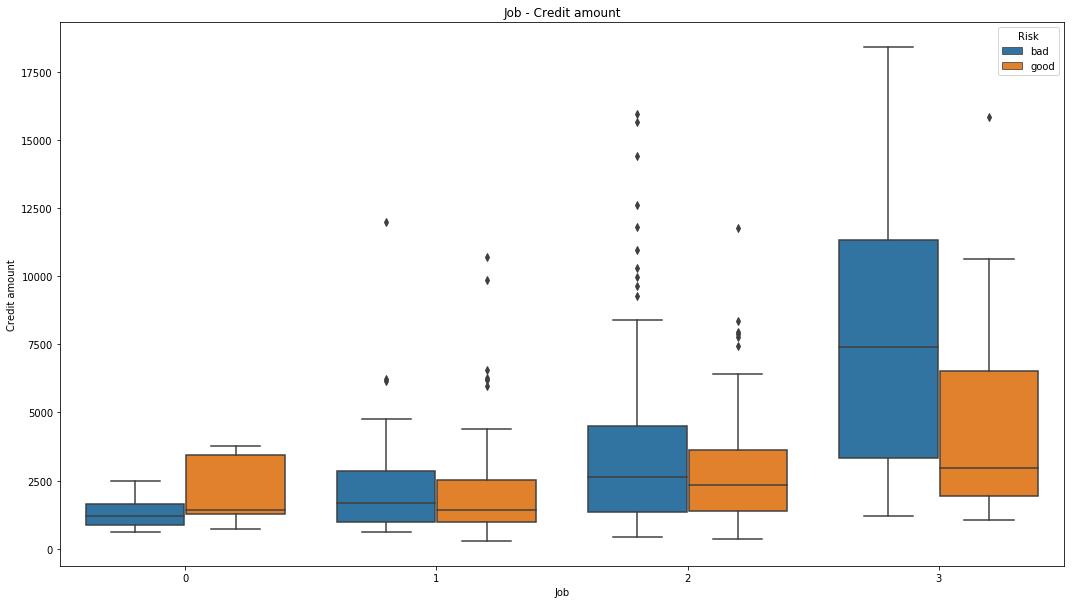

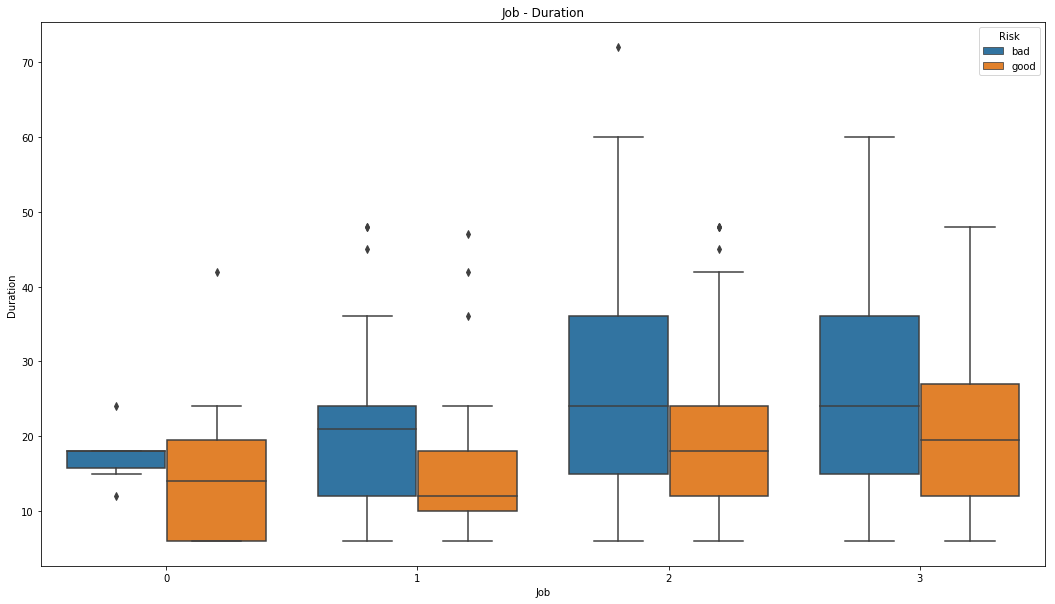

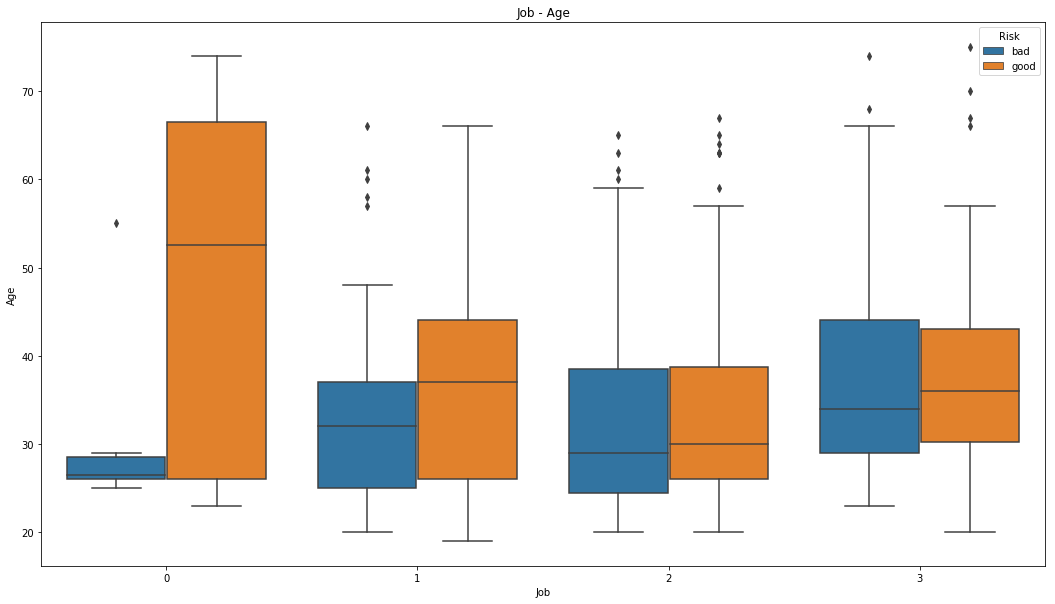

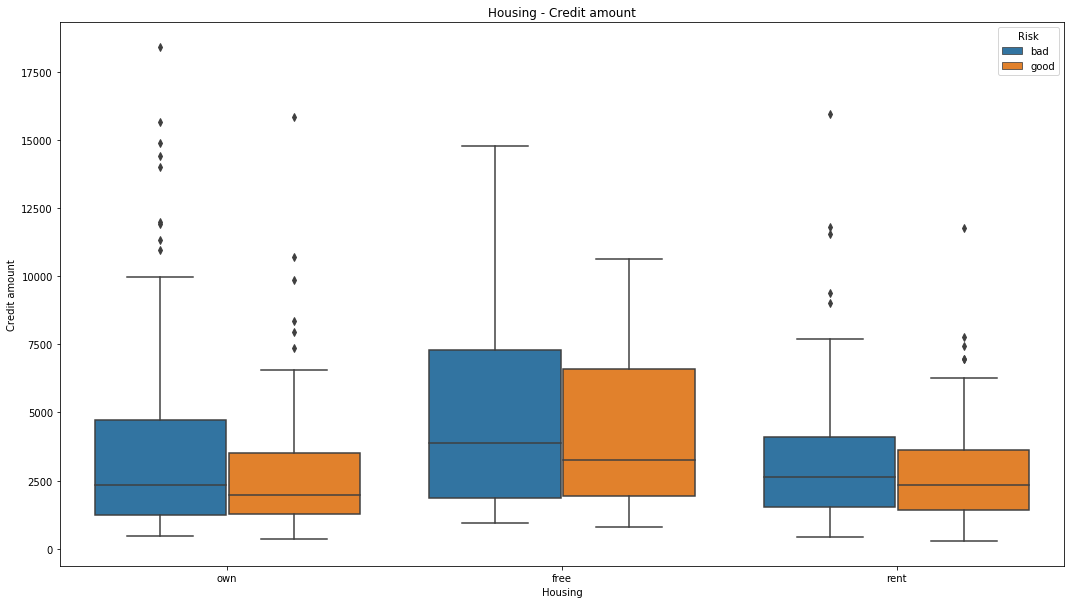

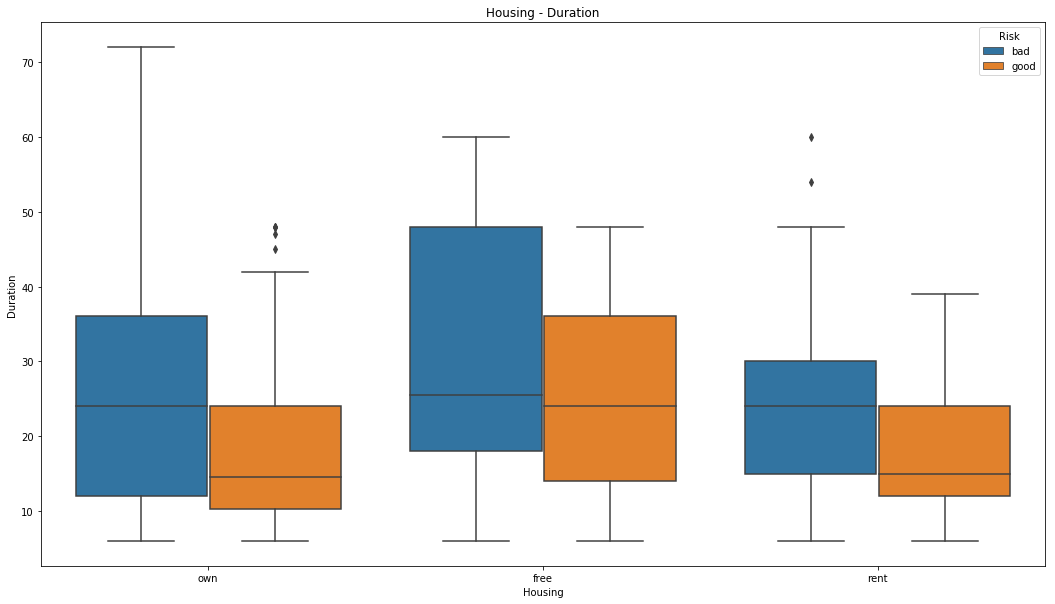

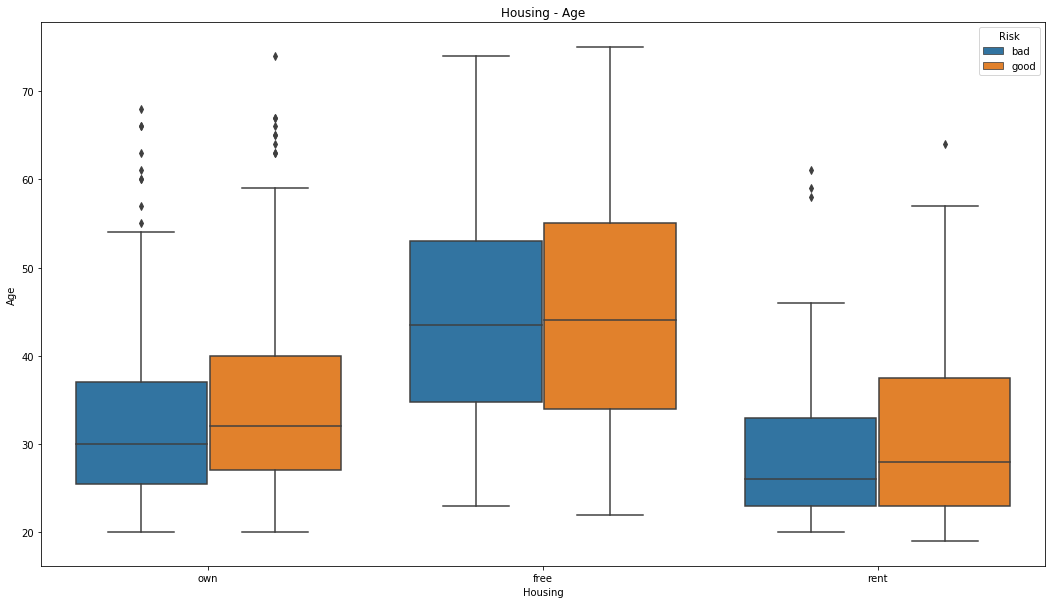

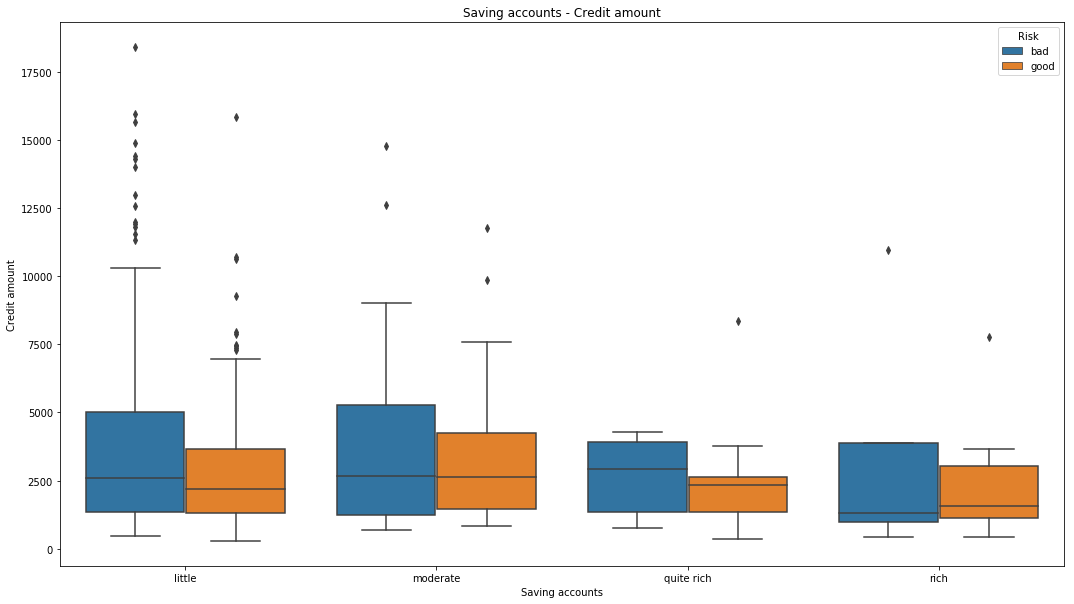

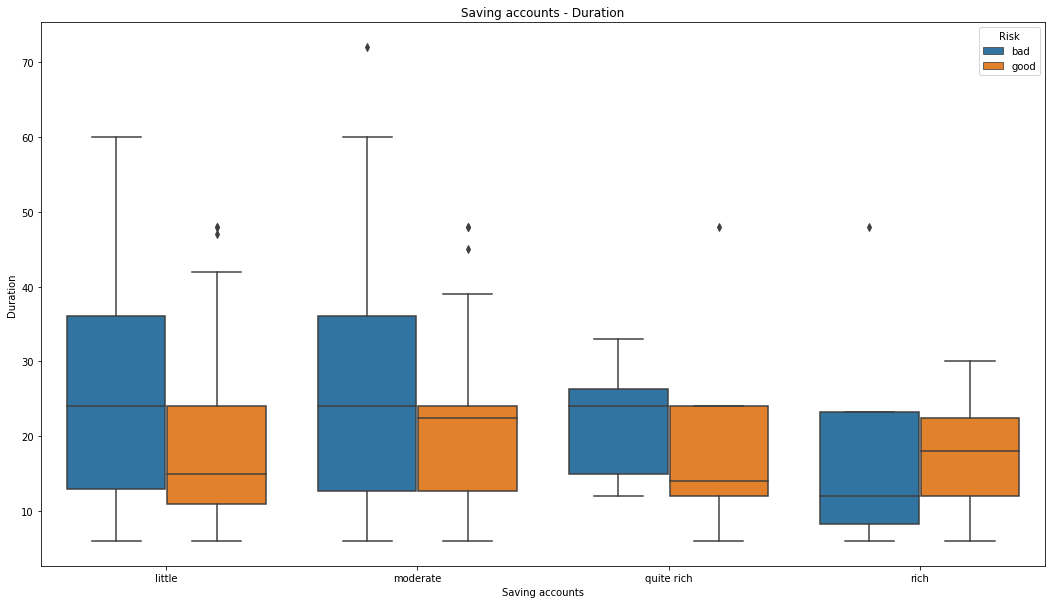

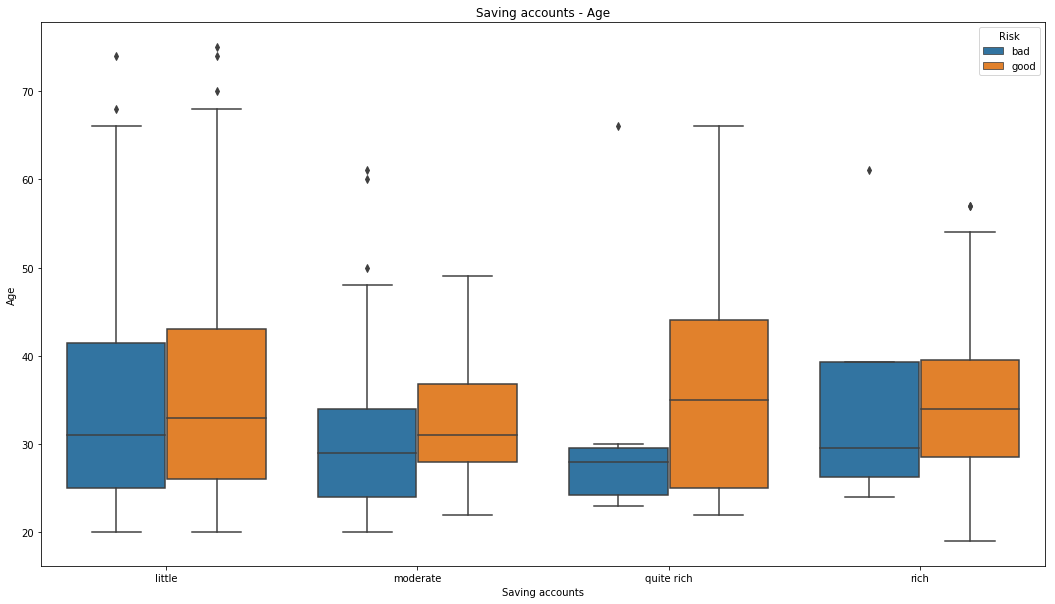

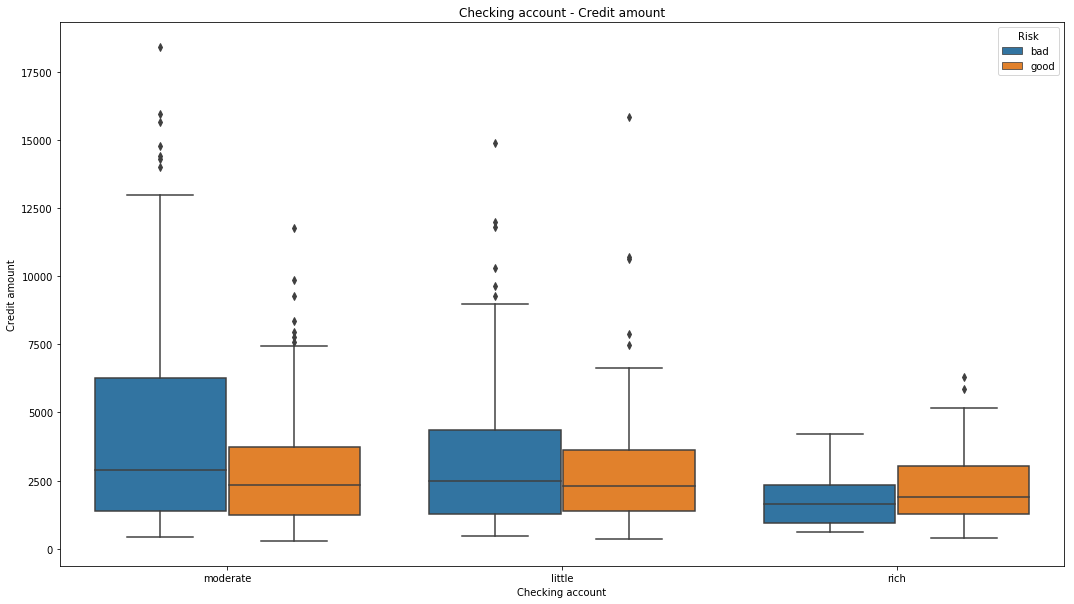

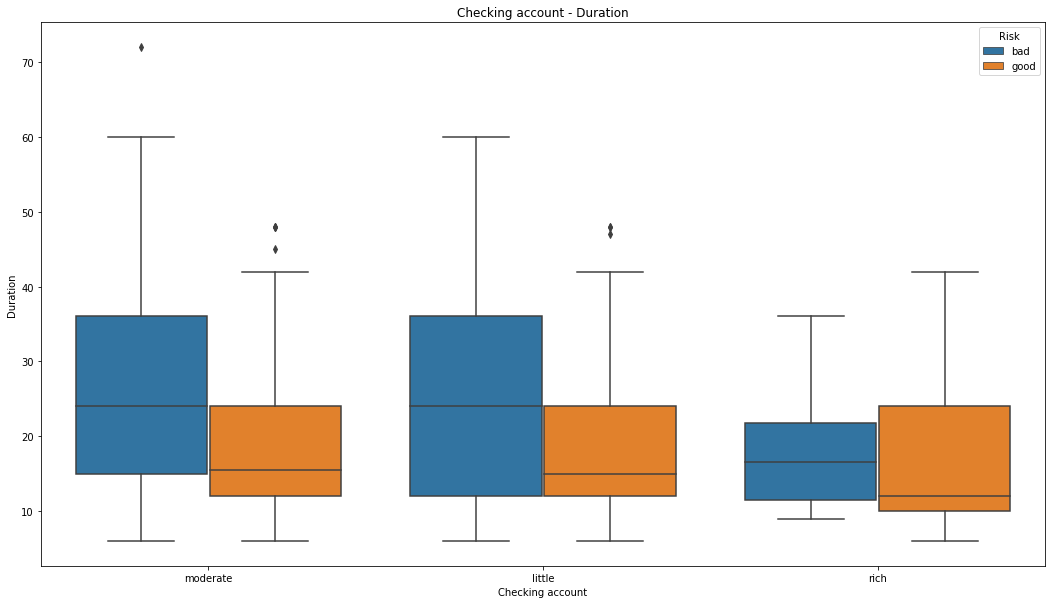

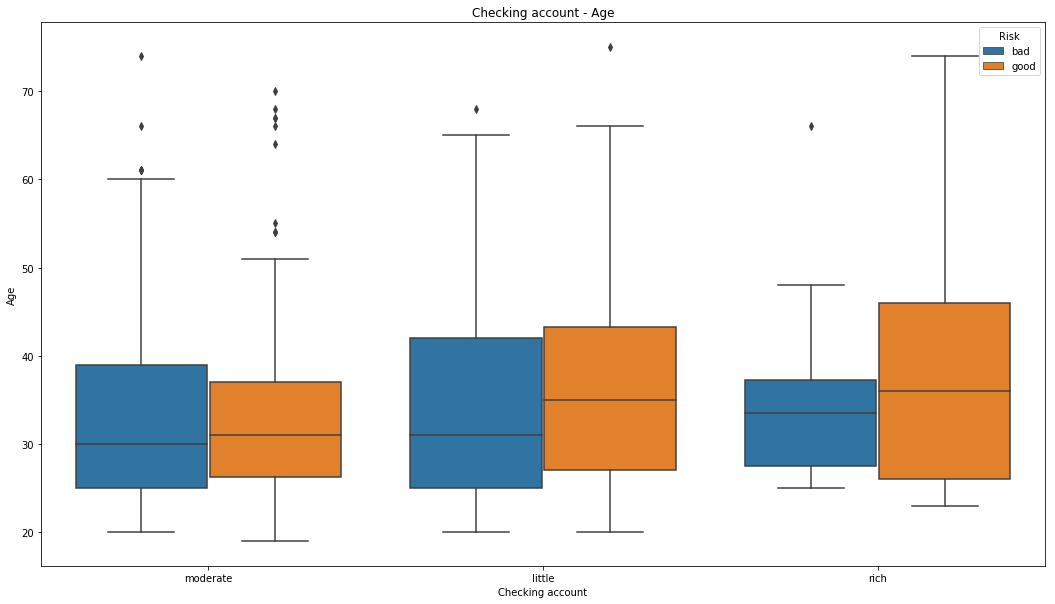

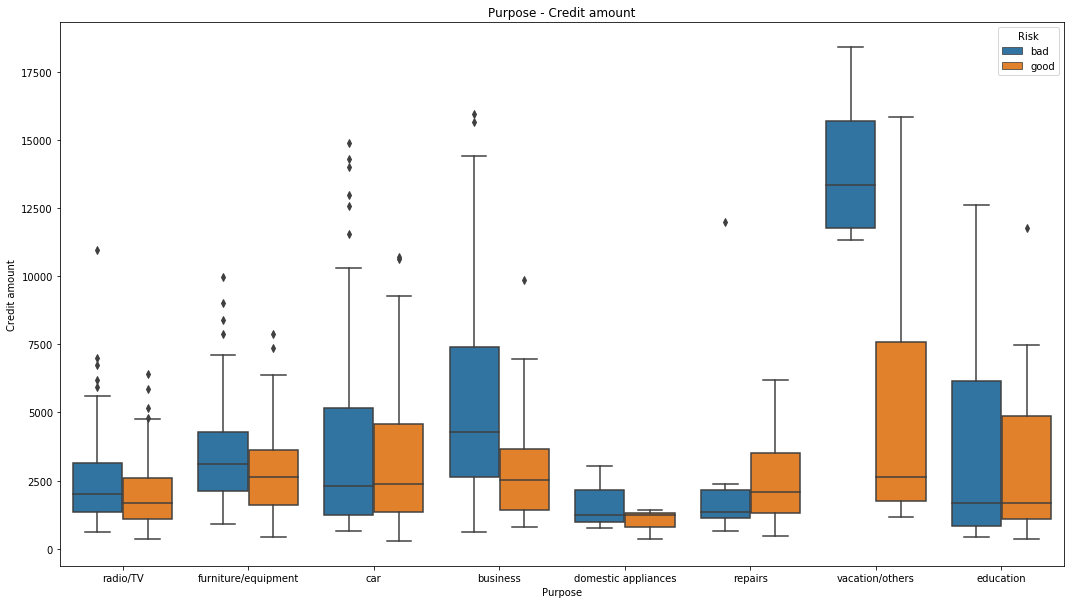

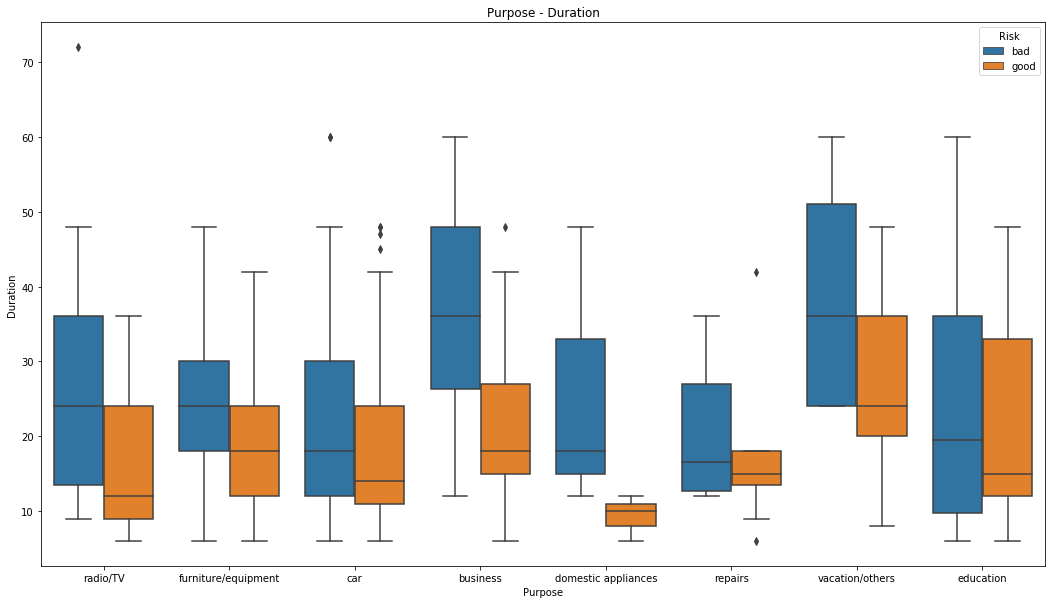

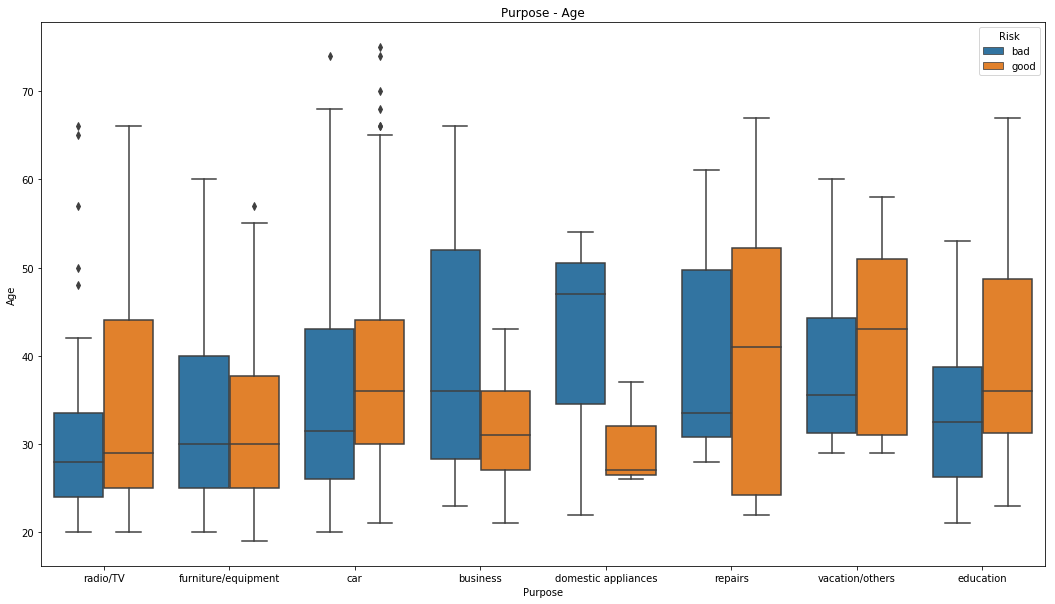

In [27]:
# check the relationship with categorical data and numerical data

def comp_cat_num(categorical_feature):
    for col in numerical_feature:
        plt.figure(figsize = (18, 10))
        sns.boxplot(x=categorical_feature, y = col, hue = 'Risk', data = df)
        plt.title('{} - {}' .format(categorical_feature, col))
        plt.show()


for i in category_feature:
    comp_cat_num(i)

In [28]:
# import matplotlib.pyplot as plt

# # boxplot for quantity data
# plotData = [df['Credit amount']]
# plt.boxplot(plotData, labels=['Credit amount'])
# plt.show()

# plotData = [df['Duration']]
# plt.boxplot(plotData, labels=['Duration'])
# plt.show()

# creditOutlier = [df for i in df['Credit amount'] if i <= 7500]
# print(creditOutlier)
# df = df[df['Credit amount'] <= 8000]
# df = df[df['Duration'] <= 50]


In [29]:
# 카테고리얼 데이터 처리

categorical = ['Sex','Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
le = preprocessing.LabelEncoder()

for cate in categorical:
    df[cate] = le.fit_transform(df[cate])
    
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
1,22,0,2,1,0,1,5951,48,5,0
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0
7,35,1,3,2,0,1,6948,36,1,1
9,28,1,3,1,0,1,5234,30,1,0


In [30]:

# X and y variables
X = df.drop('Risk', axis = 1)
y = df['Risk']

# re-scale

robustScaler = RobustScaler()
X = pd.DataFrame(robustScaler.fit_transform(X), columns=X.columns)




# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state = 42)


In [31]:
# X and y variables
X = df.drop('Risk', axis = 1)
y = df['Risk']

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state = 42)

In [32]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

LR: 0.769363 (0.089803)
LDA: 0.781630 (0.088762)
KNN: 0.676981 (0.119731)
CART: 0.611567 (0.072607)
NB: 0.821766 (0.072078)
RF: 0.630035 (0.087558)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

SVM: 1.000000 (0.000000)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Job